In [7]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [8]:
df = pd.read_csv('../data/processed/Totalchargesfixed.csv')
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 1. Correlation Matrix

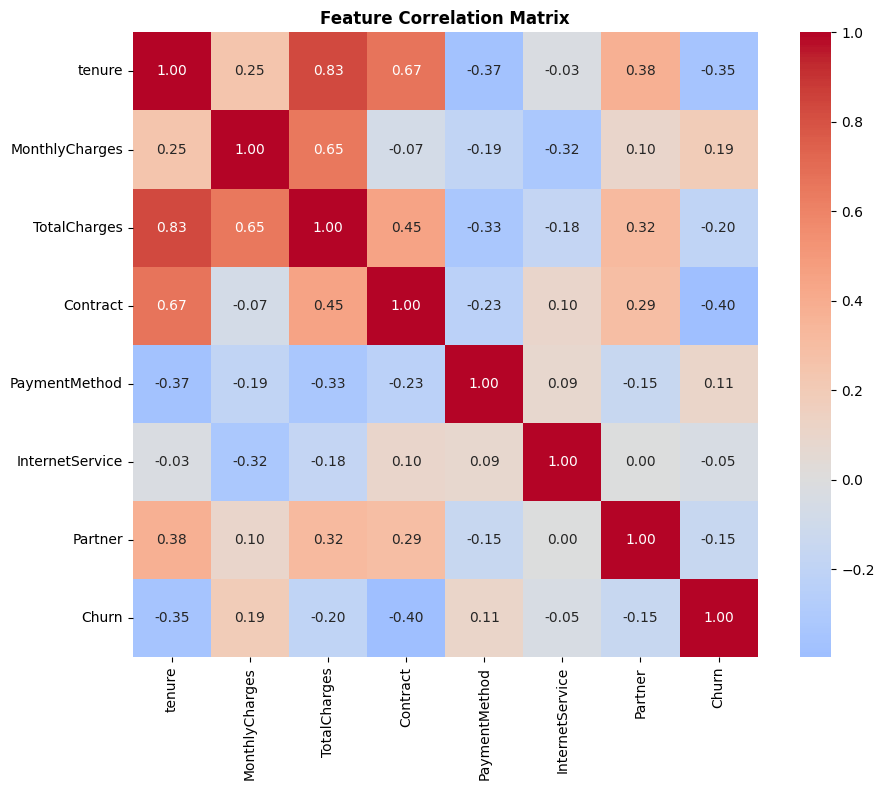


Strongest correlations with Churn:
Contract: 0.397
tenure: 0.352
TotalCharges: 0.198
MonthlyCharges: 0.193
Partner: 0.150
PaymentMethod: 0.107
InternetService: 0.047


In [9]:

df_corr = df.copy()
le = LabelEncoder()

categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 
                       'InternetService', 'Contract', 'PaymentMethod', 'Churn']

for col in categorical_features:
    if col in df_corr.columns:
        df_corr[col] = le.fit_transform(df_corr[col])


key_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Contract', 
                'PaymentMethod', 'InternetService', 'Partner', 'Churn']


correlation_matrix = df_corr[key_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title('Feature Correlation Matrix', fontweight='bold')
plt.tight_layout()
plt.show()


churn_corr = correlation_matrix['Churn'].abs().sort_values(ascending=False)
print("\nStrongest correlations with Churn:")
for feature, corr in churn_corr.items():
    if feature != 'Churn':
        print(f"{feature}: {corr:.3f}")

### 2. Feature Interactions

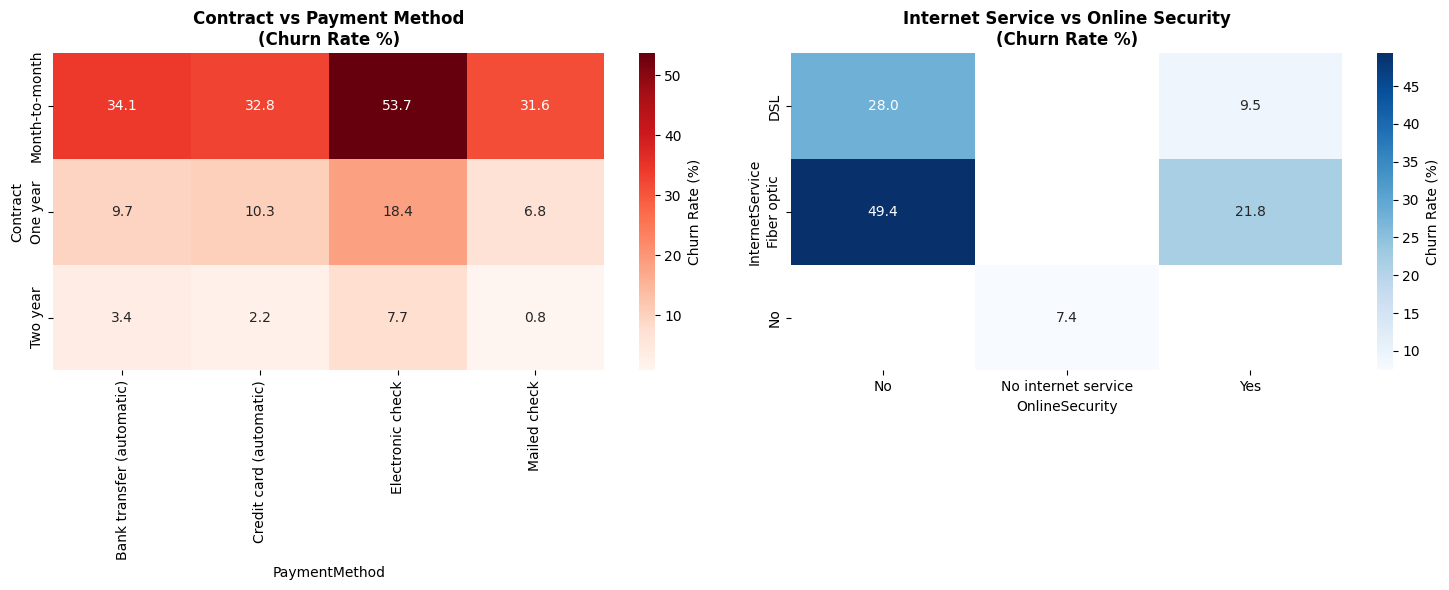

Key Interaction Insights:
Contract + Payment Method combinations:
  Month-to-month + Electronic check: 53.7% churn
  Month-to-month + Bank transfer (automatic): 34.1% churn
  Month-to-month + Credit card (automatic): 32.8% churn


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))


interaction_1 = df.groupby(['Contract', 'PaymentMethod'])['Churn'].apply(
    lambda x: (x == 'Yes').mean() * 100
).unstack()

sns.heatmap(interaction_1, annot=True, fmt='.1f', cmap='Reds', 
            ax=axes[0], cbar_kws={'label': 'Churn Rate (%)'})
axes[0].set_title('Contract vs Payment Method\n(Churn Rate %)', fontweight='bold')


interaction_2 = df.groupby(['InternetService', 'OnlineSecurity'])['Churn'].apply(
    lambda x: (x == 'Yes').mean() * 100
).unstack()

sns.heatmap(interaction_2, annot=True, fmt='.1f', cmap='Blues', 
            ax=axes[1], cbar_kws={'label': 'Churn Rate (%)'})
axes[1].set_title('Internet Service vs Online Security\n(Churn Rate %)', fontweight='bold')

plt.tight_layout()
plt.show()


print("Key Interaction Insights:")
print("Contract + Payment Method combinations:")
top_risk_combos = interaction_1.stack().sort_values(ascending=False).head(3)
for (contract, payment), rate in top_risk_combos.items():
    print(f"  {contract} + {payment}: {rate:.1f}% churn")

### 3. Customer Segmentation


Customer Segments Analysis:
                   Churn_Rate_%  Avg_Tenure  Avg_Monthly  Avg_Total
CustomerSegment                                                    
Loyal_HighSpend           14.88       58.33        88.03    5171.25
Loyal_LowSpend             3.47       56.49        26.16    1473.01
New_HighSpend             59.64        4.97        75.99     384.84
New_LowSpend              30.81        4.41        28.99     125.80
Regular_HighSpend         33.76       24.01        80.49    1938.23
Regular_LowSpend           8.21       23.13        26.89     617.93


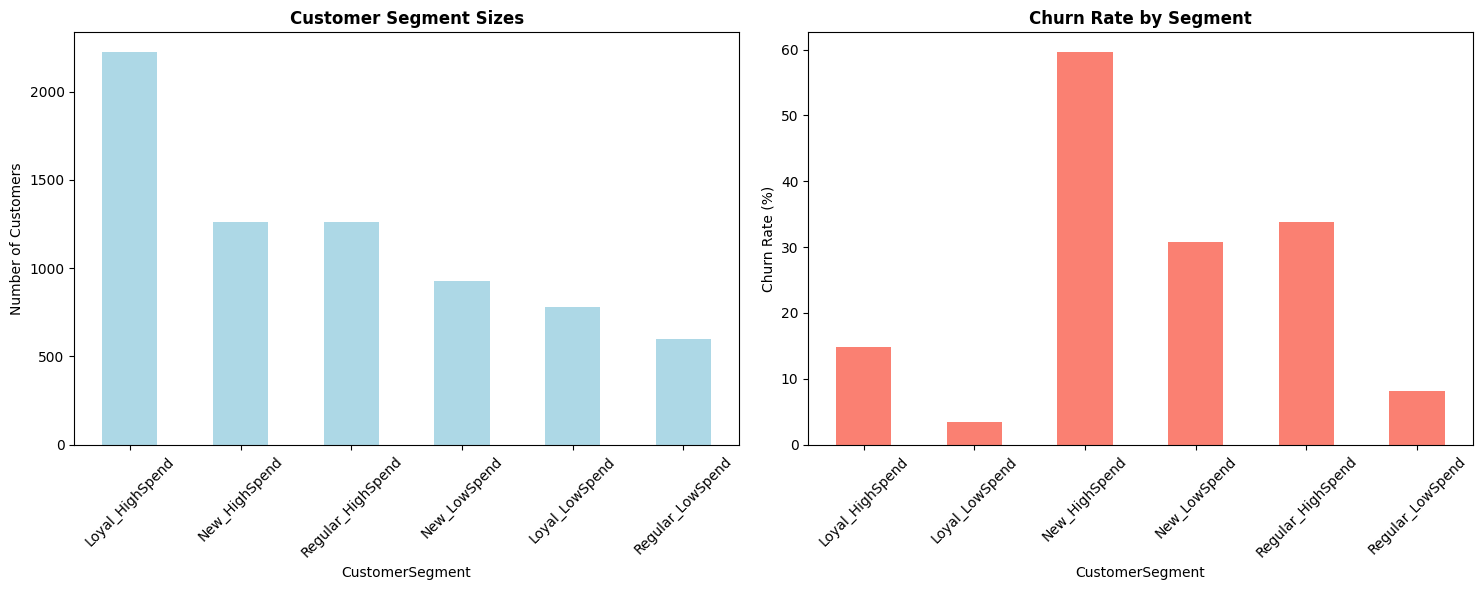

In [11]:

def create_segments(row):
    # Segment based on tenure and monthly charges
    if row['tenure'] <= 12:
        if row['MonthlyCharges'] <= 50:
            return 'New_LowSpend'
        else:
            return 'New_HighSpend'
    elif row['tenure'] <= 36:
        if row['MonthlyCharges'] <= 50:
            return 'Regular_LowSpend'
        else:
            return 'Regular_HighSpend'
    else:
        if row['MonthlyCharges'] <= 50:
            return 'Loyal_LowSpend'
        else:
            return 'Loyal_HighSpend'

df['CustomerSegment'] = df.apply(create_segments, axis=1)


segment_analysis = df.groupby('CustomerSegment').agg({
    'Churn': lambda x: (x == 'Yes').mean() * 100,
    'tenure': 'mean',
    'MonthlyCharges': 'mean',
    'TotalCharges': 'mean'
}).round(2)

segment_analysis.columns = ['Churn_Rate_%', 'Avg_Tenure', 'Avg_Monthly', 'Avg_Total']

print("\nCustomer Segments Analysis:")
print(segment_analysis)

# Visualize segments
fig, axes = plt.subplots(1, 2, figsize=(15, 6))


segment_counts = df['CustomerSegment'].value_counts()
segment_counts.plot(kind='bar', ax=axes[0], color='lightblue')
axes[0].set_title('Customer Segment Sizes', fontweight='bold')
axes[0].set_ylabel('Number of Customers')
axes[0].tick_params(axis='x', rotation=45)


churn_by_segment = df.groupby('CustomerSegment')['Churn'].apply(
    lambda x: (x == 'Yes').mean() * 100
)
churn_by_segment.plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Churn Rate by Segment', fontweight='bold')
axes[1].set_ylabel('Churn Rate (%)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### 4. Key Insights

In [13]:

high_risk_segments = churn_by_segment.sort_values(ascending=False).head(3)
print("\nHighest Risk Segments:")
for i, (segment, rate) in enumerate(high_risk_segments.items(), 1):
    print(f"{i}. {segment}: {rate:.1f}% churn rate")


print(f"\nMulticollinearity Check:")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = abs(correlation_matrix.iloc[i, j])
        if corr_val > 0.7:  # High correlation threshold
            high_corr_pairs.append((correlation_matrix.columns[i], 
                                   correlation_matrix.columns[j], corr_val))

if high_corr_pairs:
    print("High correlations found:")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"  {feat1} - {feat2}: {corr:.3f}")
else:
    print("No high multicollinearity detected")




Highest Risk Segments:
1. New_HighSpend: 59.6% churn rate
2. Regular_HighSpend: 33.8% churn rate
3. New_LowSpend: 30.8% churn rate

Multicollinearity Check:
High correlations found:
  tenure - TotalCharges: 0.826
